# AutoEncoder(tensorflow)

參考資料：
- [Tensorflow Day18 Convolutional Autoencoder - iT 邦幫忙::一起幫忙解決難題，拯救 IT 人的一天](https://ithelp.ithome.com.tw/articles/10188326)

- [利用卷积自编码器对图片进行降噪 - 知乎](https://zhuanlan.zhihu.com/p/27902193)

- [Tensorflow Day 7 : 實作 MNIST 卷積神經網路 Convolutional Neural Network - iT 邦幫忙::一起幫忙解決難題，拯救 IT 人的一天](https://ithelp.ithome.com.tw/articles/10187149)

## 載入 MNIST

In [1]:
#import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

/home/allenyl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 定義helper function

In [35]:
def weight_variable(shape, name='W'):
    w = tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1), name=name)
    # summary op
    tf.summary.histogram('weights', w)
    return w
def bias_variable(shape, name='B'):
    b = tf.Variable(tf.constant(0.1, shape=shape), name=name)
    # summary op
    tf.summary.histogram('biases', b)
    return b

In [36]:
def plot_n_reconstruct(origin_img, reconstruct_img, n =10):
    
    plt.figure(figsize=(40*10/n, 8*10/n))
    
    for i in range(n):
        # display origin
        ax = plt.subplot(2, n, i+1)
        plt.imshow(origin_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruct
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(reconstruct_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
def plot_n_code(code, n=10):
    from matplotlib import gridspec
    gs = gridspec.GridSpec(1, n, wspace=0.2) 
    
    plt.figure(figsize=(40*10/n,4*10/n))

    for i in range(n):

        x_code = range(len(code[i]))
        y_code = code[i]

        width = 0.5

        #ax = plt.subplot(1, n, i+1)
        ax = plt.subplot(gs[i])
        #ax.set_figheight(28)
        #ax.set_figwidth(28)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.bar(x_code,y_code, width)

    plt.show()
    
    
def plot_n_code_compare(code1, code2):
    import numpy as np

    n = len(code1)
    
    code = np.concatenate((code1,code2), axis=0)

    plt.figure(figsize=(2*10,4))

    for i in range(n):

        x_code = range(len(code[i]))
        y_code = code[i]

        width = 0.5

        ax = plt.subplot(2, 10, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.bar(x_code,y_code, width)

        y_code = code[i+n]
        ax = plt.subplot(2, 10, i+1+n)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.bar(x_code,y_code, width)

    plt.show()

## Normal Auto Encoder

784->300->30->300->784

- [tf.nn.dropout  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)

- [谈谈Tensorflow的dropout - 简书](https://www.jianshu.com/p/c9f66bc8f96c)

    > 使输入tensor中某些元素变为0，其它没变0的元素变为原来的1/keep_prob大小！

    > 个人总结：个人感觉除非是大型网络，才采用dropout，不然我感觉自己在一些小型网络上，训练好像很是不爽。之前搞一个比较小的网络，搞人脸特征点定位的时候，因为训练数据不够，怕过拟合，于是就采用dropout，最后感觉好像训练速度好慢，从此就对dropout有了偏见，感觉训练过程一直在波动，很是不爽。

- [How do you plot training and validation loss on the same graph using TensorFlow’s TensorBoard? - Quora](https://www.quora.com/How-do-you-plot-training-and-validation-loss-on-the-same-graph-using-TensorFlow%E2%80%99s-TensorBoard)

- [decentralion/tf-dev-summit-tensorboard-tutorial: Code that accompanies my talk at TF Dev Summit 2016](https://github.com/decentralion/tf-dev-summit-tensorboard-tutorial)

- [Hands-on TensorBoard (TensorFlow Dev Summit 2017)](https://youtu.be/eBbEDRsCmv4)

- [[翻译]TensorBoard - 简书](https://www.jianshu.com/p/7d698cebf5f1)

    > 启动TensorBoard
    >
    > 用下面命令启动TensorBoard（或者`python -m tensorflow.tensorboard`）
    >
    > ```
    > tensorboard --logdir=path/to/log-directory
    >
    > ```
    >
    > logir指向FileWriter序列化数据的地方。如果logdir目录包含其他运行的子目录，TensorBoard将把全部数据可视化。TensorBoard运行后，用浏览器到`localhost:6006`查看。

- [tf.summary.image  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/summary/image)
- [tf.summary.FileWriter  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter)
- [How to use tensorboard Embedding Projector? - Stack Overflow](https://stackoverflow.com/questions/40849116/how-to-use-tensorboard-embedding-projector)


In [55]:
import os

class Autoencoder:
    def __init__(self):
        tf.reset_default_graph() # reset graph
        
        self.init_input_place() # init placeholder
        
        self.h_e, self.w, self.h_d = self.build_ae() # build graph

        self.loss_func() # define loss function
        
        init_op = tf.global_variables_initializer() # define initialize operation
        
        self.sess = tf.InteractiveSession() # open new session
        self.sess.run(init_op) # run initialze operation
        self.init_summary(self.sess) # init tensorboard summary log
        self.embedding_summary()
        
    def init_input_place(self):
        with tf.name_scope('input_data'):
            self.x_input = tf.placeholder(tf.float32, shape=[None, 784], name='x_input')
            self.x_input_reshape = tf.reshape(self.x_input, [-1, 28, 28, 1]) #28 X 28 X 1

            self.x_target = self.x_input
            self.x_target_reshape = self.x_input_reshape
        
        with tf.name_scope('control_variable'):
            self.keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')
        
    def loss_func(self):
        with tf.name_scope('cost'):
            self.x_reconstruct = self.h_d[-1]
            loss = tf.pow((self.x_reconstruct - self.x_target),2)
            self.cost = tf.reduce_mean(loss)

        with tf.name_scope('train_step'):
            self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)
        
    def init_summary(self, sess):
        self.summaries_dir = "/tmp/tensorflowlogs"
        # 定義 summary op
        tf.summary.image('input', self.x_input_reshape, 3)
        tf.summary.image('output', tf.reshape(self.x_reconstruct, shape=[-1, 28, 28, 1]), 3)
        self.cost_summary = tf.summary.scalar('cost', self.cost)
        self.merged_summary = tf.summary.merge_all()
        # summary writer
        self.train_writer = tf.summary.FileWriter(self.summaries_dir + '/train', sess.graph)
        self.test_writer = tf.summary.FileWriter(self.summaries_dir + '/test')
    
    def embedding_summary(self):
        LABELS = os.path.join(os.getcwd(), "labels_1024.tsv")
        SPRITES = os.path.join(os.getcwd(), "sprite_1024.png")
        
        ### define embedding input ###
        self.embedding_input = self.h_e[-1]
        #print(self.h_e[-1].shape)
        self.embedding_size = self.h_e[-1].shape[1]
        ##############################
        
        embedding = tf.Variable(tf.zeros([1024, self.embedding_size]), name="test_embedding")
        self.assignment = embedding.assign(self.embedding_input)
        self.saver = tf.train.Saver()
        
        config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
        embedding_config = config.embeddings.add()
        embedding_config.tensor_name = embedding.name
        # test data 的 縮圖路徑
        embedding_config.sprite.image_path = SPRITES
        # test data 的 label 路徑
        embedding_config.metadata_path = LABELS
        # Specify the width and height of a single thumbnail.
        embedding_config.sprite.single_image_dim.extend([28, 28])
        tf.contrib.tensorboard.plugins.projector.visualize_embeddings(self.test_writer, config)
    
    def build_ae(self):

        decoder_list = []
        encoder_list = []
        weight_list = []

        ### encoder ###
        with tf.name_scope('encoder'):
            w = weight_variable([784,300])
            b = bias_variable([300])
            h = tf.nn.sigmoid(tf.add(tf.matmul(self.x_input, w), b))
            out = h
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)

            w = weight_variable([300,30])
            b = bias_variable([30])
            h = tf.nn.sigmoid(tf.add(tf.matmul(out, w), b))
            out = h
            # get original layer shape
            # out_shape = out.shape.as_list()
            # out_shape[0] = -1 # batch size must be -1
            out_shape = tf.shape(out)
            # flatten layer
            out = tf.layers.Flatten()(out)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)
            
            # restore shape
            out = tf.reshape(out, shape=out_shape)
        
        ### decoder ###
        with tf.name_scope('decoder'):
            w = weight_variable([30, 300])
            b = bias_variable([300])
            h = tf.nn.sigmoid(tf.add(tf.matmul(out, w), b))
            out = h
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

            w = weight_variable([300, 784])
            b = bias_variable([784])
            h = tf.nn.sigmoid(tf.add(tf.matmul(out, w), b))
            out = h
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

        return encoder_list, weight_list, decoder_list


    def train_data_gen(self,n=60, keep_prob=1):
        batch = mnist.train.next_batch(n)[0]
        return batch, {self.x_input:batch, self.keep_prob:keep_prob}
    
    def test_data_gen(self,n=10, keep_prob=1):
        batch = mnist.test.images[0:n, :]
        return batch, {self.x_input:batch, self.keep_prob:keep_prob}
    
    def train(self, epoch=20000, keep_prob=1):

        for i in range(epoch):
            _, train_feed_dict = self.train_data_gen(n=60, keep_prob=keep_prob)
            if i < 1500:
                if i % 100 == 0:
                    print("step %d, loss %g" % (i, self.cost.eval(feed_dict=train_feed_dict)))
            else:
                if i % 1000 == 0:
                    print("step %d, loss %g" % (i, self.cost.eval(feed_dict=train_feed_dict)))

            
            ### write tensorboard summary ###
            if i % 200 == 0:
                # test cost
                _, test_feed_dict = self.test_data_gen(-1)
                # 執行 summary op
                #summary = self.cost_summary.eval(feed_dict=test_feed_dict)
                # collect all summaries
                summary = self.merged_summary.eval(feed_dict=test_feed_dict)
                self.test_writer.add_summary(summary, i)
                self.test_writer.flush()
                ### save embedding project ###
                _, test_feed_dict = self.test_data_gen(1024)
                self.sess.run(self.assignment, feed_dict=test_feed_dict)
                self.saver.save(self.sess, os.path.join(self.summaries_dir, "model.ckpt"), i)
                ##############################
                
            # train cost
            # 執行 summary op
            # collect cost summary
            summary = self.cost_summary.eval(feed_dict=train_feed_dict)
            #summary = self.merged_summary.eval(feed_dict=train_feed_dict)
            self.train_writer.add_summary(summary, i)
            self.train_writer.flush()
            
            ### update ###
            self.optimizer.run(feed_dict=train_feed_dict)

        _, test_feed_dict = self.test_data_gen(-1)
        print("final loss %g" % self.cost.eval(feed_dict=test_feed_dict))

        for h_i in self.h_e:
            print("average output activation value %g" % tf.reduce_mean(h_i).eval(feed_dict=test_feed_dict))
            
    def plot_test(self, test_size=10, draw_code=True):
        test_origin_img, test_feed_dict = self.test_data_gen(test_size)
        test_reconstruct_img = self.x_reconstruct.eval(feed_dict=test_feed_dict)
        print(self.x_reconstruct.shape)

        plot_n_reconstruct(test_origin_img, test_reconstruct_img, n=test_size)
        
        code = 0
        if draw_code:
            code = tf.layers.Flatten()(self.h_e[-1]).eval(feed_dict=test_feed_dict)
            print(code.shape)

            plot_n_code(code, n=test_size)
        
        return code
    
    def plot_decode(self,code):
        import numpy as np
        n = len(code[0])
        temp = np.zeros(shape=(n,784))
        #test_reconstruct_img = self.sess.run(self.x_reconstruct, feed_dict={self.x_input:temp,tf.layers.Flatten()(self.h_e[-1]):code})
        print("code shape:", code.shape)
        #test_reconstruct_img = self.sess.run(self.x_reconstruct, feed_dict={self.h_e[-1]:code})
        print("layer shape:", self.h_e[-1].shape)
        #code_shape = self.h_e[-1].get_shape().as_list()
        
        test_reconstruct_img = self.sess.run(self.x_reconstruct, feed_dict={self.x_input:temp, self.h_e[-1]:code, self.keep_prob:1})
    
        

        origin_img = test_reconstruct_img
        #code = code_test

        print("image shape:", origin_img.shape)
        plt.figure(figsize=(2*10, 12))

        for i in range(n):
            # display origin
            ax = plt.subplot(6, 10, (int(i/10)*20 + i%10)+1)
            plt.imshow(origin_img[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # plot code
            x_code = range(len(code[i]))
            y_code = code[i]

            width = 0.5

            ax = plt.subplot(6, 10, (((int(i/10))*20+10)  + i % 10) +1 )
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.bar(x_code,y_code, width)

        plt.show()

In [56]:
ae = Autoencoder()

ae.train(20000, 1)

code_non_sparse = ae.plot_test(test_size=10)

/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 0.279419
step 100, loss 0.0687411
step 200, loss 0.0621394
step 300, loss 0.0575279
step 400, loss 0.0497289
step 500, loss 0.0479828
step 600, loss 0.0419475
step 700, loss 0.0395024
step 800, loss 0.041145
step 900, loss 0.0404512
step 1000, loss 0.0342066
step 1100, loss 0.0315725
step 1200, loss 0.033282
step 1300, loss 0.0319185
step 1400, loss 0.032371
step 2000, loss 0.0271873
step 3000, loss 0.0205335
step 4000, loss 0.0174814


KeyboardInterrupt: 

### 畫出每個維度特徵圖

code shape: (30, 30)
layer shape: (?, 30)
image shape: (30, 784)


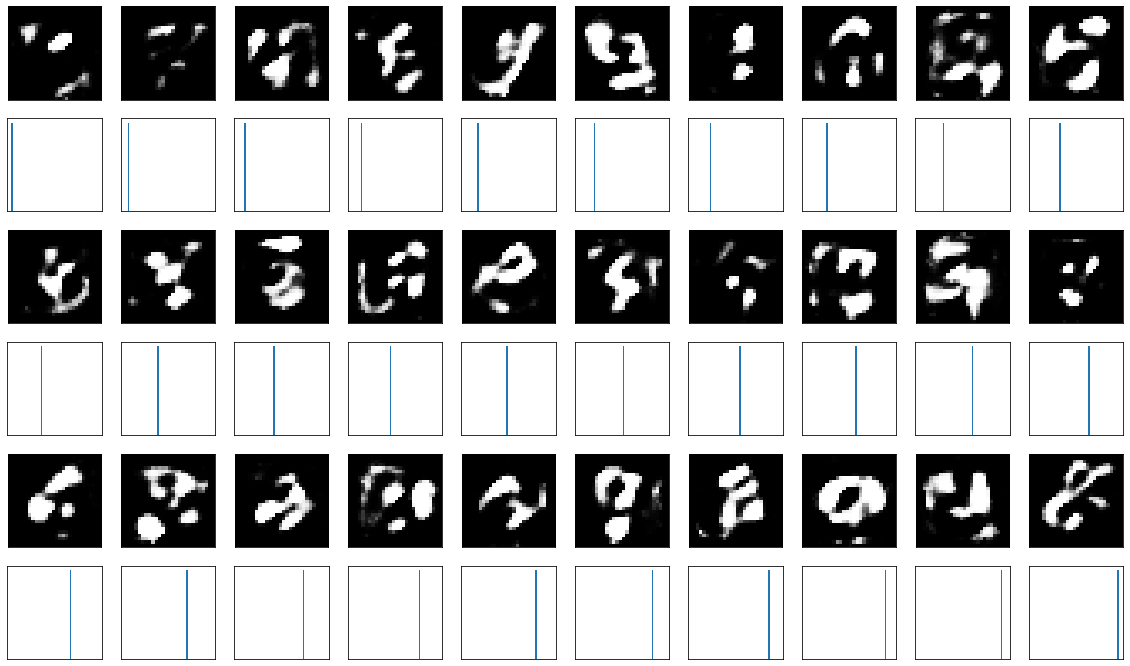

In [6]:
import numpy as np
code_test = np.zeros(shape=(30,30))

for i in range(30):
    code_test[i][i] = 15
    
ae.plot_decode(code_test)

## Sparse Auto encoder

### Loss function

In [7]:
def logfunc(x, x2):
    return tf.multiply(x, tf.log(tf.div(x,x2)))

def kl_div(rho, rho_hat):
    invrho = tf.subtract(tf.constant(1.),rho)
    invrhohat = tf.subtract(tf.constant(1.),rho_hat)
    logrho = tf.add(logfunc(rho, rho_hat), logfunc(invrho, invrhohat))
    return logrho

In [8]:
class SparseAutoencoder(Autoencoder):
    def loss_func(self):
        from functools import reduce
        alpha = 0
        beta = 7.5e-2
        kl_div_loss = reduce(lambda x, y: x+y, 
                             map(lambda x: tf.reduce_sum(kl_div(0.02, tf.reduce_mean(x,0))), 
                                 [self.h_e[-1]]))
        l2_loss = reduce(lambda x, y: x+y, map(lambda x:tf.nn.l2_loss(x), self.w))

        self.x_reconstruct = self.h_d[-1]
        reconstruct_loss = tf.reduce_mean(tf.pow(self.x_reconstruct - self.x_target_reshape, 2))
        self.cost = reconstruct_loss + alpha * l2_loss + beta * kl_div_loss
        self.optimizer = tf.train.AdamOptimizer(0.01).minimize(self.cost)


/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 1.5361
step 100, loss 0.0661351
step 200, loss 0.0697986
step 300, loss 0.0661438
step 400, loss 0.0639068
step 500, loss 0.0644498
step 600, loss 0.0640718
step 700, loss 0.0623058
step 800, loss 0.060508
step 900, loss 0.0571814
step 1000, loss 0.0524742
step 1100, loss 0.0573263
step 1200, loss 0.0545307
step 1300, loss 0.0462347
step 1400, loss 0.0469446
step 2000, loss 0.0365801
step 3000, loss 0.0286722
step 4000, loss 0.0225614
step 5000, loss 0.022934
step 6000, loss 0.0180666
step 7000, loss 0.0176094
step 8000, loss 0.0157035
step 9000, loss 0.0150438
step 10000, loss 0.0146269
step 11000, loss 0.0143039
step 12000, loss 0.0138989
step 13000, loss 0.0159356
step 14000, loss 0.010966
step 15000, loss 0.0137434
step 16000, loss 0.0110818
step 17000, loss 0.0119844
step 18000, loss 0.0109568
step 19000, loss 0.00993391
step 20000, loss 0.0127476
step 21000, loss 0.0112391
step 22000, loss 0.0109016
step 23000, loss 0.0105064
step 24000, loss 0.011012
step 25000, los

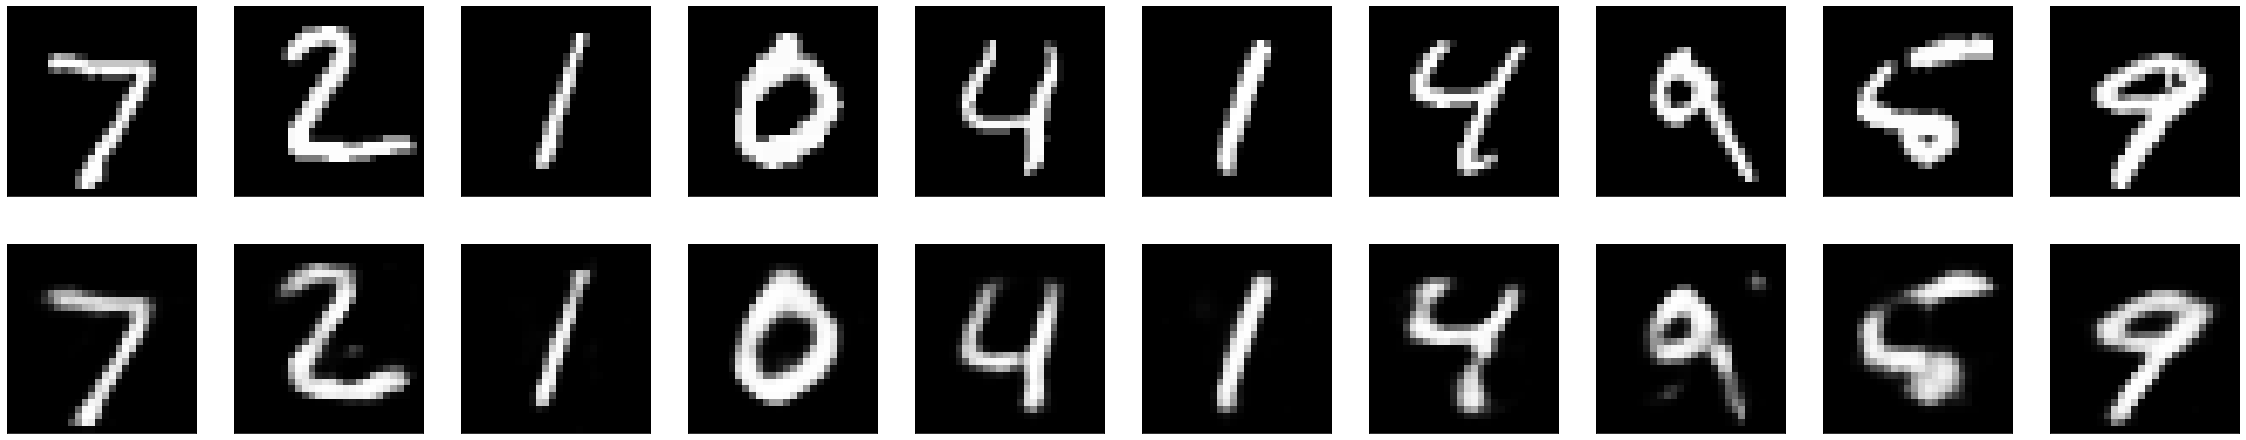

(10, 30)


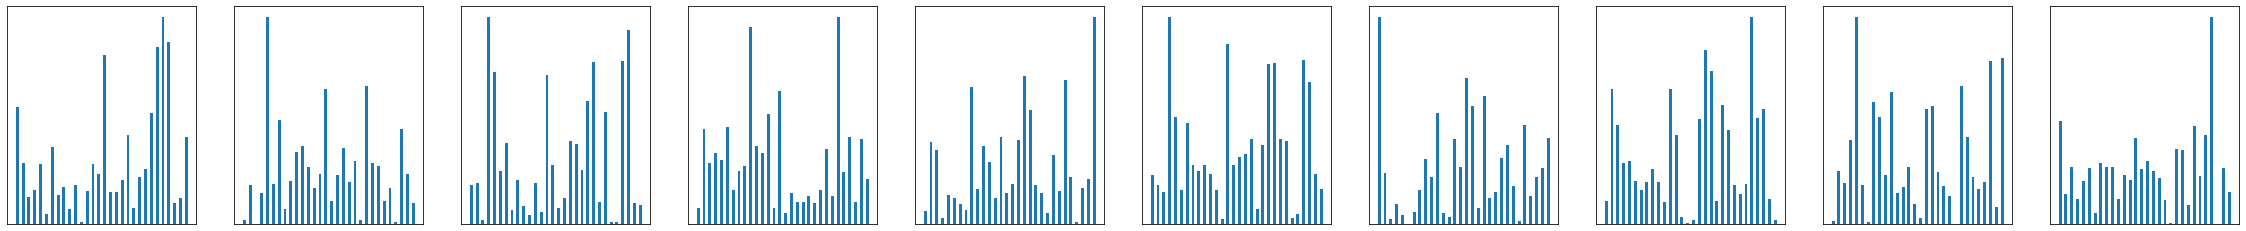

In [9]:
sae = SparseAutoencoder()

sae.train(30000)

code_sparse = sae.plot_test(test_size=10)


### 畫出每個維度特徵圖

code shape: (30, 30)
layer shape: (?, 30)
image shape: (30, 784)


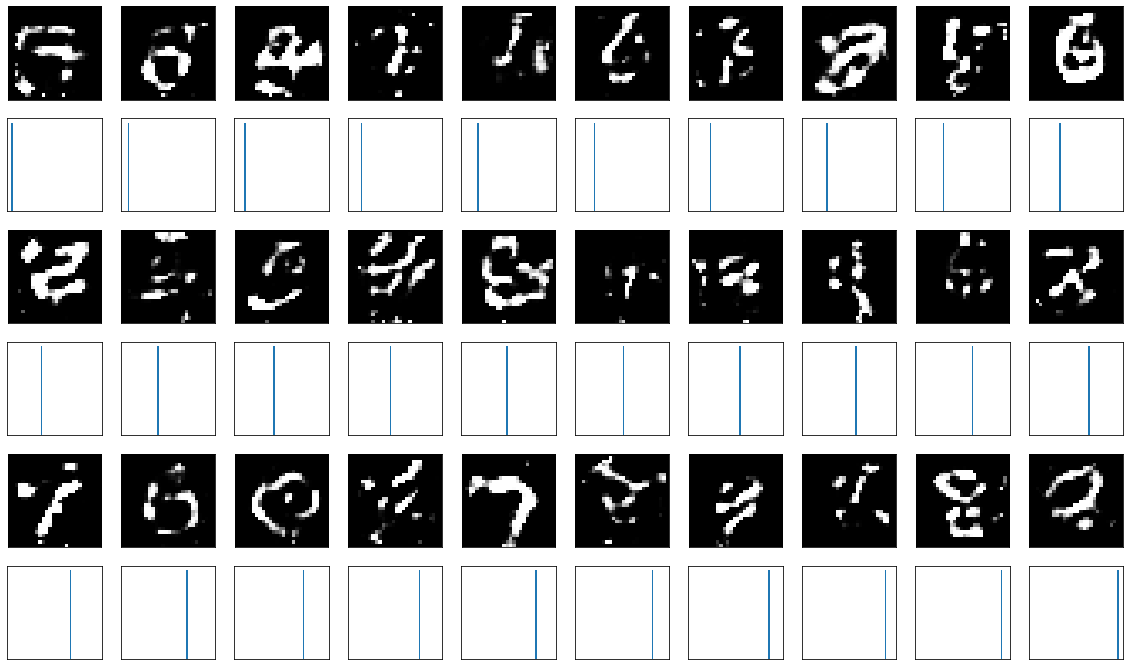

In [10]:
code_test = np.zeros(shape=(30,30))

for i in range(30):
    code_test[i][i] = 0.6
    
sae.plot_decode(code_test)

## 比較 non-sparse 與 sparse

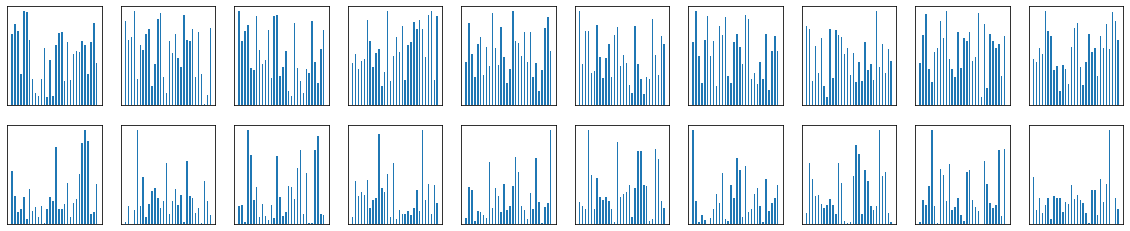

In [11]:
plot_n_code_compare(code_non_sparse, code_sparse)

## Convolution Auto Encoder (with stride 2X2, 卷積核每次移動2格)

In [12]:
def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1,2,2,1], padding='SAME')

def deconv2d(x, w, output_shape):
    return tf.nn.conv2d_transpose(x, w, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

In [13]:
class ConvolutionAutoEncoder(Autoencoder):
    def init_input_place(self):
        self.x_input = tf.placeholder(tf.float32, shape=[None, 784])
        self.x_input_reshape = tf.reshape(self.x_input, [-1, 28, 28, 1]) #28 X 28 X 1
        
        self.x_target = self.x_input
        self.x_target_reshape = self.x_input_reshape
        
        self.keep_prob = tf.placeholder(tf.float32)
        
    def build_ae(self):
        decoder_list = []
        encoder_list = []
        weight_list = []
        
        ### encoder ###
        w = weight_variable([5,5,1,64], "w_e_conv1")
        b = bias_variable([64], "b_e_conv1")
        h = tf.nn.relu(tf.add(conv2d(self.x_input_reshape, w), b)) # 14 X 14 X 64
        out = h
        # add to list
        encoder_list.append(out)
        weight_list.append(w)
        

        w = weight_variable([5,5,64,1], "w_e_conv2")
        b = bias_variable([1], "b_e_conv2")
        h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 7 X 7 X 1
        out = h
        # add to list
        encoder_list.append(out)
        weight_list.append(w)


        # get original layer shape
        out_shape = out.shape.as_list()
        out_shape[0] = -1 # batch size must be -1
        # flatten layer
        out = tf.layers.Flatten()(out)
        # add to list
        encoder_list.append(out)
        # restore shape
        out = tf.reshape(out, shape=out_shape)
        
        
        ### decoder ###
        w = weight_variable([5,5,64,1], "w_d_conv1")
        b = bias_variable([64], "b_d_conv1")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
        h = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 14 X 14 X 64
        out = h
        # add to list
        decoder_list.append(out)
        weight_list.append(w)
        
        
        w = weight_variable([5,5,1,64], "w_d_conv2")
        b = bias_variable([1], "b_d_conv1")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 1])
        h = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 28 X 28 X 1
        out = h
        # add to list
        decoder_list.append(out)
        weight_list.append(w)

        return encoder_list, weight_list, decoder_list
    
    def plot_conv_layer(self, layer, image, num_filters):
        import math
        output = self.sess.run(layer, feed_dict = {self.x_input: [image], self.keep_prob:1})

        num_grids = int(math.ceil(math.sqrt(num_filters)))

        fig, axes = plt.subplots(num_grids, num_grids)

        for i, ax in enumerate(axes.flat):
            if i < num_grids * num_grids:
                img = output[0, :, :, i]
                ax.imshow(img, interpolation='nearest', cmap='gray')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()

/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 0.0973783
step 100, loss 0.0287296
step 200, loss 0.0215963
step 300, loss 0.0202803
step 400, loss 0.0184677
step 500, loss 0.0184728
step 600, loss 0.0180518
step 700, loss 0.0174543
step 800, loss 0.0173354
step 900, loss 0.0175492
step 1000, loss 0.0163407
step 1100, loss 0.0168416
step 1200, loss 0.0184874
step 1300, loss 0.0164781
step 1400, loss 0.0174601
step 2000, loss 0.0157463
step 3000, loss 0.0163603
step 4000, loss 0.0146791
step 5000, loss 0.0146229
step 6000, loss 0.014229
step 7000, loss 0.0148154
step 8000, loss 0.0138255
step 9000, loss 0.0168626
step 10000, loss 0.0157287
step 11000, loss 0.0136381
step 12000, loss 0.0151369
step 13000, loss 0.0145235
step 14000, loss 0.0143204
step 15000, loss 0.013962
step 16000, loss 0.0151913
step 17000, loss 0.00799671
step 18000, loss 0.00736622
step 19000, loss 0.00685791
final loss 0.00753606
average output activation value 0.07652
average output activation value 1.55878
average output activation value 1.55878
(

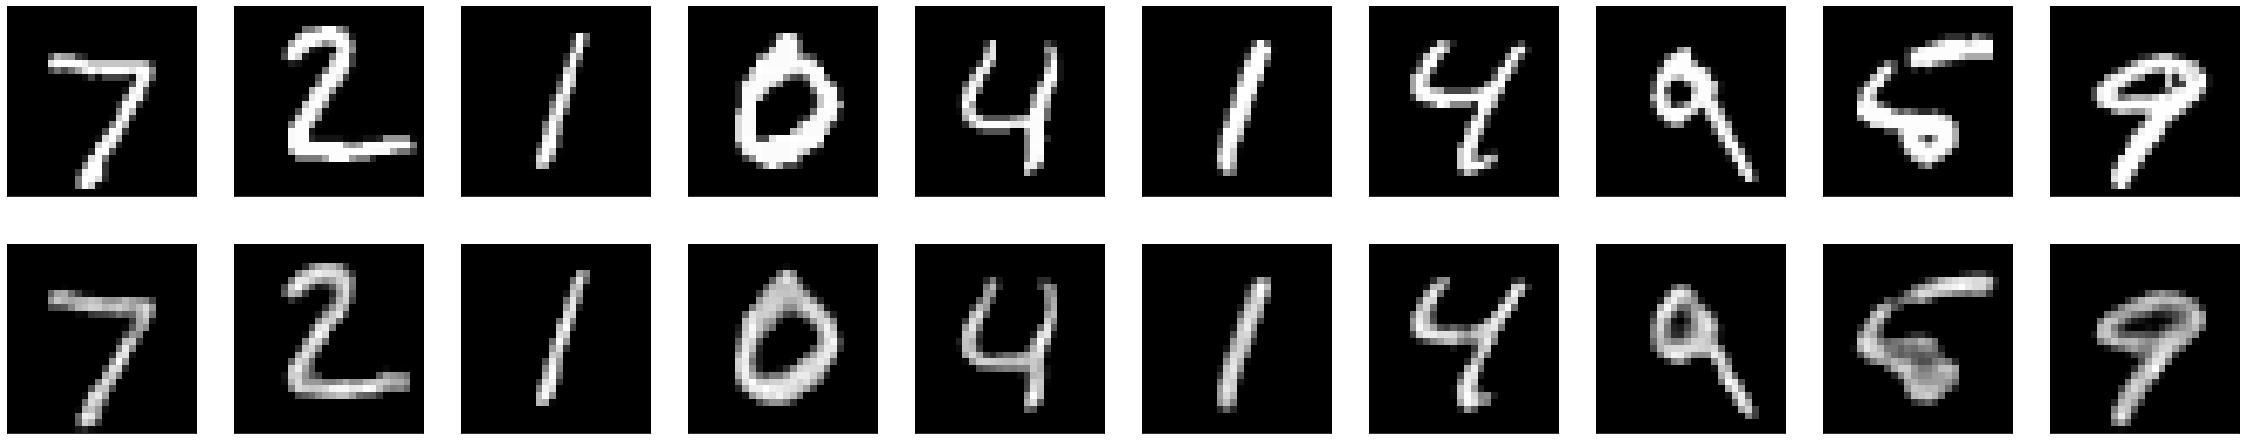

(10, 49)


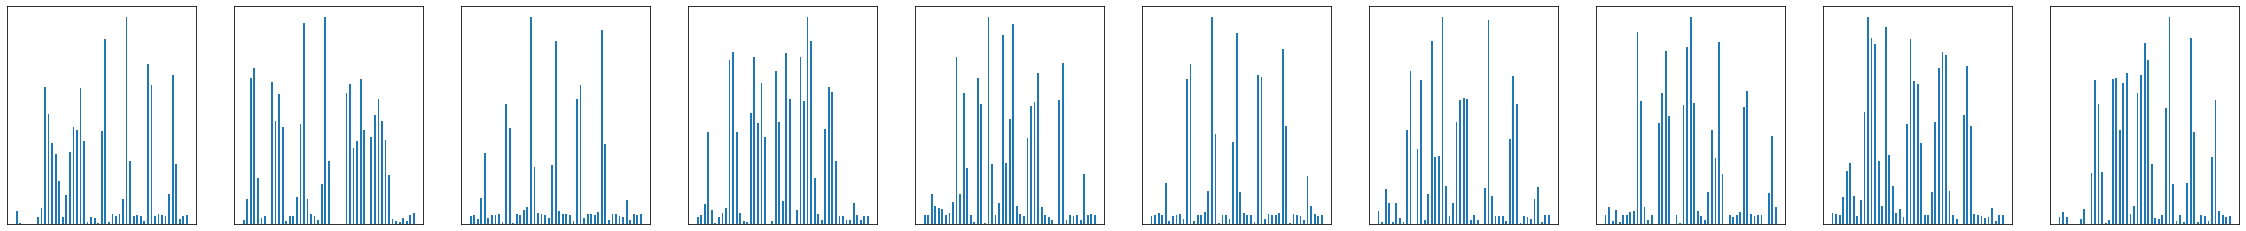

In [14]:
conv_ae = ConvolutionAutoEncoder()

conv_ae.train(20000)

code = conv_ae.plot_test(10, draw_code=True)

### 畫出第一層filter

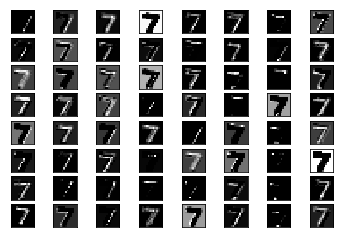

In [15]:
image1 = mnist.test.images[0]
conv_ae.plot_conv_layer(conv_ae.h_e[0], image1, 64)

## Convolution Auto Encoder with max pooling

- [Tensorflow Day18 Convolutional Autoencoder - iT 邦幫忙::一起幫忙解決難題，拯救 IT 人的一天](https://ithelp.ithome.com.tw/articles/10188326)

    使用 `tf.nn.max_pool_with_argmax` 這個函數，它除了會回傳 pooling 的結果外也會回傳對應原本的索引值 (argmax)，如下．

    > The indices in argmax are flattened, so that a maximum value at position [b, y, x, c] becomes flattened index ((b * height + y) * width + x) * channels + c.

    理論上在做 unpooling 的時就會用到這裡產生的對應表．不過目前 tensorflow 中沒有 unpooling 這個 op (可以參考 [issue](https://github.com/tensorflow/tensorflow/issues/2169))．因此以下展示了兩種方法作 unpooling 也都不會用到 argmax．

    1.  使用 Github Issue 討論中的方法，也就是放大兩倍後在固定的地方填值 (ex. 左上角)

    2.  借用影像的 upsample 函數 `tf.image.resize_nearest_neighbor` 來做等比例放大，也就不會補 0．
    
- [tf.nn.max_pool_with_argmax  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool_with_argmax)
- [tf.zeros_like  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/zeros_like)
- [tf.concat  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/concat)
- [tf.image.resize_images  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/image/resize_images)


In [16]:
#convolution, deconvolution, pooling, unpooling

def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def deconv2d(x, w, output_shape):
    return tf.nn.conv2d_transpose(x, w, output_shape, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    print("max_pool_2x2")
    print(x.shape)
    out = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    print(out.shape)
    return out

def max_unpool_2x2(x, shape):
    print("max_unpool_2x2")
    print(x.shape)
    # NEAREST_NEIGHBOR 速度最快，效果跟 BILINEAR, BICUBIC 差不多，但 BICUBIC 非常慢
    inference = tf.image.resize_images(x, [shape[1], shape[2]], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    print(inference.shape)
    return inference

def max_unpool_2x2_fill_zero(x, output_shape):
    print("max_unpool_2x2_fill_zero")
    print(x.shape)
    out = tf.concat([x, tf.zeros_like(x)], 3)
    out = tf.concat([out, tf.zeros_like(out)], 2)
    out_size = output_shape
    out = tf.reshape(out, out_size)
    print(out.shape)
    return out

In [17]:
class ConvolutionMaxpoolFillZeroAutoEncoder(ConvolutionAutoEncoder):
    def build_ae(self):
        decoder_list = []
        encoder_list = []
        weight_list = []
        
        ### encoder ###
        w = weight_variable([5,5,1,64], "w_e_conv1")
        b = bias_variable([64], "b_e_conv1")
        h = tf.nn.relu(tf.add(conv2d(self.x_input_reshape, w), b)) # 28 X 28 X 64
        out = max_pool_2x2(h) # 14 X 14 X 64
        # add to list
        encoder_list.append(out)
        weight_list.append(w)
        

        w = weight_variable([5,5,64,1], "w_e_conv2")
        b = bias_variable([1], "b_e_conv2")
        h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 14 X 14 X 1
        out = max_pool_2x2(h) # 7 X 7 X 1
        # add to list
        encoder_list.append(out)
        weight_list.append(w)

        # get original layer shape
        out_shape = out.shape.as_list()
        out_shape[0] = -1 # batch size must be -1
        # flatten layer
        out = tf.layers.Flatten()(out)
        # add to list
        encoder_list.append(out)
        # restore shape
        out = tf.reshape(out, shape=out_shape)
        
        ### decoder ###
        w = weight_variable([5,5,64,1], "w_d_conv1")
        b = bias_variable([64], "b_d_conv1")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 7, 7, 64])
        h = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 7 X 7 X 64
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
        out = max_unpool_2x2_fill_zero(h, output_shape) # 14 X 14 X 64
        # add to list
        decoder_list.append(out)
        weight_list.append(w)
        
        
        w = weight_variable([5,5,1,64], "w_d_conv2")
        b = bias_variable([1], "b_d_conv1")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 1])
        h = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 14 X 14 X 1
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 1])
        out = max_unpool_2x2_fill_zero(h, output_shape) # 28 X 28 X 1
        # add to list
        decoder_list.append(out)
        weight_list.append(w)

        return encoder_list, weight_list, decoder_list

/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


max_pool_2x2
(?, 28, 28, 64)
(?, 14, 14, 64)
max_pool_2x2
(?, 14, 14, 1)
(?, 7, 7, 1)
max_unpool_2x2_fill_zero
(?, 7, 7, 64)
(?, 14, 14, 64)
max_unpool_2x2_fill_zero
(?, 14, 14, 1)
(?, 28, 28, 1)
step 0, loss 0.114428
step 100, loss 0.089766
step 200, loss 0.0918157
step 300, loss 0.0899035
step 400, loss 0.0876665
step 500, loss 0.0877791
step 600, loss 0.0882108
step 700, loss 0.0875731
step 800, loss 0.0881624
step 900, loss 0.0796747
step 1000, loss 0.0847868
step 1100, loss 0.0899127
step 1200, loss 0.0835615
step 1300, loss 0.0857375
step 1400, loss 0.0823149
step 2000, loss 0.0869386
step 3000, loss 0.0797532
step 4000, loss 0.0877455
step 5000, loss 0.0894803
step 6000, loss 0.0864092
step 7000, loss 0.0816241
step 8000, loss 0.0799483
step 9000, loss 0.0794242
step 10000, loss 0.092437
step 11000, loss 0.0891711
step 12000, loss 0.0810339
step 13000, loss 0.0830646
step 14000, loss 0.0834387
step 15000, loss 0.0866145
step 16000, loss 0.0873275
step 17000, loss 0.0891936
step 

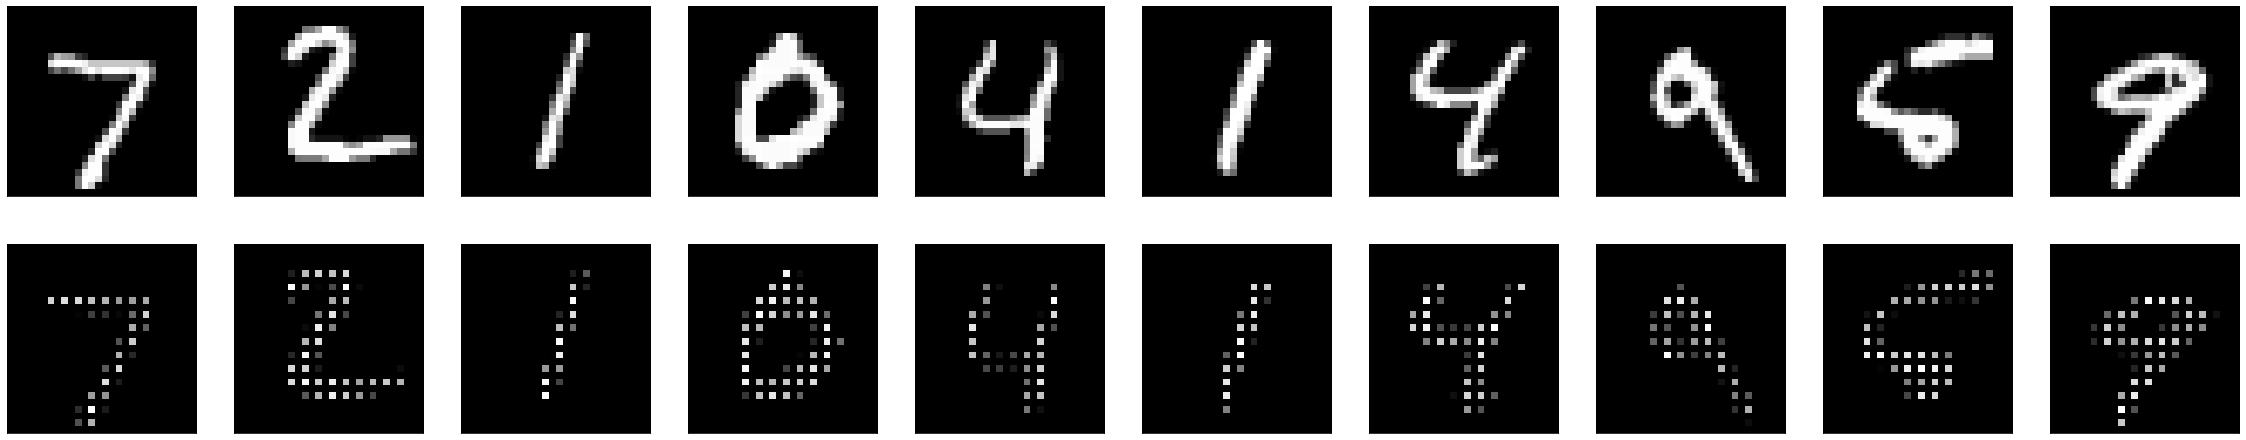

(10, 49)


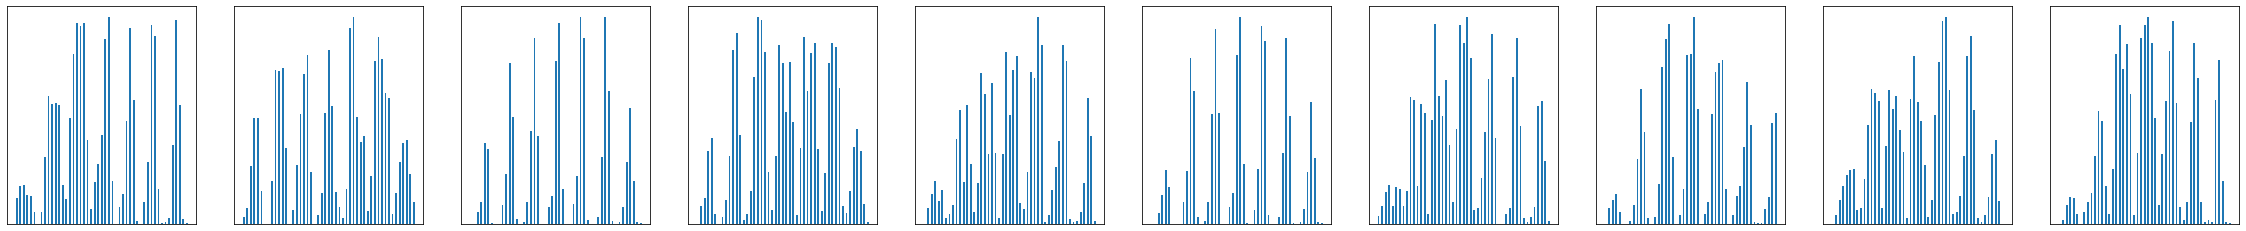

In [18]:
convmax_ae = ConvolutionMaxpoolFillZeroAutoEncoder()

convmax_ae.train(20000)

code = convmax_ae.plot_test(10, draw_code=True)

### 畫出第一層filter

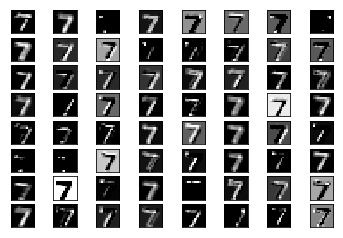

In [19]:
image1 = mnist.test.images[0]
convmax_ae.plot_conv_layer(convmax_ae.h_e[0], image1, 64)

### max_unpool_2x2 補零法

In [20]:
# 在越後方的維度表示越內層括號
test = tf.constant([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]]) # 2 X 2 X 3
print(test.eval()[:,:,0]) # 印出 2 X 2

# 從內層括號新增 0 之後 reshape 到外層，就會產生插入0的效果
test_out = tf.concat([test, tf.zeros_like(test)], 2) # 2 X 2 X 6
test_out = test_out.eval().reshape([2,4,3]) # 2 X 4 X 3
print(test_out[:,:,0]) # 印出 2 X 4

# 再做一次新增 0 reshape，就會產生原始數字在左上角，其他為0的效果
test_out = tf.concat([test_out, tf.zeros_like(test_out)], 1) # 2 X 8 X 3
test_out = test_out.eval().reshape([4,4,3]) # 4 X 4 X 3
print(test_out[:,:,0]) # 印出 4 X 4

[[ 1  4]
 [ 7 10]]
[[ 1  0  4  0]
 [ 7  0 10  0]]
[[ 1  0  4  0]
 [ 0  0  0  0]
 [ 7  0 10  0]
 [ 0  0  0  0]]


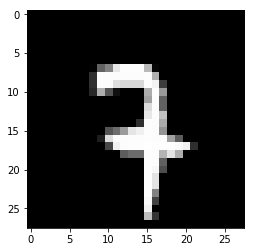

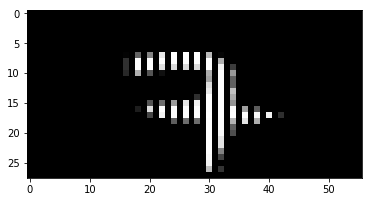

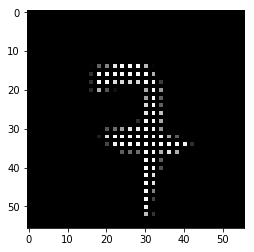

In [21]:
# 在越後方的維度表示越內層括號
batch = mnist.train.next_batch(60)
x = batch[0]
x_origin = tf.reshape(x, [-1, 28, 28, 1])

plt.imshow(x_origin.eval()[0,:,:,0])
plt.gray()
plt.show()

# 從內層括號新增 0 之後 reshape 到外層，就會產生插入0的效果
out = tf.concat([x_origin, tf.zeros_like(x_origin)], 3) # -1 X 28 X 28 X 2
out = tf.reshape(out, [-1, 28, 56, 1]) # -1 X 28 X 56 X 1

plt.imshow(out.eval()[0,:,:,0])
plt.gray()
plt.show()

# 再做一次新增 0 reshape，就會產生原始數字在左上角，其他為0的效果
out = tf.concat([out, tf.zeros_like(out)], 2) # -1 X 28 X 112 X 1
out = tf.reshape(out, [-1, 56, 56, 1]) # -1 X 56 X 56 X 1

plt.imshow(out.eval()[0,:,:,0])
plt.gray()
plt.show()

## Sparse Convolution AutoEncoder with max pooling

- [TF里几种loss和注意事项 - 知乎](https://zhuanlan.zhihu.com/p/33560183)

    > **准备1、**先说一下什么是logit，logit函数定义为：
    > 
    > ![L(p)=ln\frac{p}{1-p}](https://www.zhihu.com/equation?tex=L%28p%29%3Dln%5Cfrac%7Bp%7D%7B1-p%7D)
    > 
    > 是一种将取值范围在\[0,1\]内的概率映射到实数域\[-inf,inf\]的函数，如果p=0.5，函数值为0；p<0.5，函数值为负；p>0.5，函数值为正。
    > 
    > **相对地**，softmax和sigmoid则都是将\[-inf,inf\]映射到\[0,1\]的函数。
    > 
    > 在tensorflow里的"logits"指的其实是，该方法是在**logit数值**上使用softmax或者sigmoid来进行normalization的，也暗示用户**不要**将网络输出进行sigmoid或者softmax，这些过程可以在函数内部更高效地计算。
    > 
    > **准备2、**独立和互斥
    > 
    > 有事件A和B
    > 
    > 独立：P(AnB) = P(A) * P(B)
    > 
    > 互斥：P(AUB) = P(A) + P(B), P(AnB) = 0
    > 
    > **准备3、**cross entropy loss + softmax + sigmoid
    > 
    > 请看之前的文章，[复习：常见的损失函数](https://zhuanlan.zhihu.com/p/33542937)
    
    - [tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/versions/r1.4/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)
    
    计算网络输出logits和标签labels的sigmoid cross entropy loss，衡量独立不互斥离散分类任务的误差，说独立不互斥离散分类任务是因为，在这些任务中类与类之间是独立但是不互斥的，拿多分类任务中的多目标检测来举例子，一张图中可以有各种instance，比如有一只狗和一只猫。对于一个总共有五类的多目标检测任务，假如网络的输出层有5个节点，label的形式是[1,1,0,0,1]这种，1表示该图片有某种instance，0表示没有。那么，每个instance在这张图中有没有这显然是独立事件，但是多个instance可以存在一张图中，这就说明事件们并不是互斥的。所以我们可以直接将网络的输出用作该方法的logits输入，从而进行输出与label的cross entropy loss。

    更加直白的来说，这种网络的输入不需要进行one hot处理，网络输出即是函数logits参数的输入。

    剖开函数内部，因为labels和logits的形状都是[batch_size, num_classes]，那么如何计算他们的交叉熵呢，毕竟它们都不是有效的概率分布（一个batch内输出结果经过sigmoid后和不为1）。其实loss的计算是element-wise的，方法返回的loss的形状和labels是相同的，也是[batch_size, num_classes]，再调用reduce_mean方法计算batch内的平均loss。所以这里的cross entropy其实是一种class-wise的cross entropy，每一个class是否存在都是一个事件，对每一个事件都求cross entropy loss，再对所有的求平均，作为最终的loss。
    
    - [tf.nn.softmax_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/versions/r1.4/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
    
    计算网络输出logits和标签labels的softmax cross entropy loss，衡量独立互斥离散分类任务的误差，说独立互斥离散分类任务是因为，在这些任务中类与类之间是独立而且互斥的，比如VOC classification、Imagenet、CIFAR-10甚至MNIST，这些都是多分类任务，但是一张图就对应着一个类，class在图片中是否存在是独立的，并且一张图中只能有一个class，所以是独立且互斥事件。

    该函数要求每一个label都是一个有效的概率分布，对于Imagenet中的ILSVRC2012这种任务，那么label应该就对应一个one hot编码，ILSVRC2012提供的数据集中一共有1000个类，那么label就应该是一个1x1000的vector，形式为[0,0,...,1,0,....0]，1000个元素中有且只有一个元素是1，其余都是0。

    这样要求的原因很简单，因为网络的输出要进行softmax，得到的就是一个有效的概率分布，这里不同与sigmoid，因为sigmoid并没有保证网络所有的输出经过sigmoid后和为1，不是一个有效的概率分布。

    有了labels和softmax后的logits，就可以计算交叉熵损失了，最后得到的是形状为[batch_size, 1]的loss。
       
    - [tf.nn.sparse_softmax_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/versions/r1.4/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)
    
    这个版本是tf.nn.softmax_cross_entropy_with_logits的易用版本，这个版本的logits的形状依然是[batch_size, num_classes]，但是labels的形状是[batch_size, 1]，每个label的取值是从[0, num_classes)的离散值，这也更加符合我们的使用习惯，是哪一类就标哪个类对应的label。

    如果已经对label进行了one hot编码，则可以直接使用tf.nn.softmax_cross_entropy_with_logits。

In [22]:
class SparseConvolutionMaxpoolAutoEncoder(ConvolutionAutoEncoder):
    def loss_func(self):
        from functools import reduce
        
        # reconstruct
        self.x_reconstruct = self.h_d[-1]
        
        # 計算KL divergence 時，必須要通過 sigmoid，因為KL divergence 是計算機率，其中有log(1-P)項，
        # 如果沒有通過sigmoid，算出來P可能大於1，就會變成nan
        beta = 7.5e-3
        kl_div_loss = reduce(lambda x, y: x+y, 
                             map(lambda x: tf.reduce_sum(kl_div(0.02, tf.reduce_mean(x,0))), 
                                 [tf.nn.sigmoid(tf.layers.Flatten()(self.h_e[-1]))]))


        # 使用平方差loss 的話，輸出層不能加激發函數，而且decode layers 的激發函數必須用sigmoid
        # 用sigmoid就無法建立很深層的layers
        #loss = tf.pow((x_reconstruct - x_origin),2)

        # 使用cross entropy 的效果比平方差效果更好，而且隱藏層的激發函數都可以使用relu
        # relu 的好處是可以建立很深的layers
        logits_ = self.h_d[-2]
        targets_ = self.x_target_reshape
        # 思考問題：為何要用 sigmoid_cross_entropy_with_logits？
        # ans: 因為每個 pixel 的值介於0~1，可以當成機率值，計算cross entropy，又sigmoid 是element-wise計算cross entropy
        #      而softmax 是強迫所有輸出值和為1，顯然在圖片上，我們不需要所有輸出和為1。
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits_) + beta * kl_div_loss
        #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=targets_, logits=logits_) + beta * kl_div_loss
        self.cost = tf.reduce_mean(loss)

        self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)
    
    def build_ae(self):
        decoder_list = []
        encoder_list = []
        weight_list = []

        ### encoder ###
        # convolution
        w = weight_variable([5,5,1,64], "w_e_conv1")
        b = bias_variable([64], "b_e_conv1")
        h = tf.nn.relu(tf.add(conv2d(self.x_input_reshape, w), b)) # 28 X 28 X 64
        # pooling
        out = max_pool_2x2(h) # 14 X 14 X 64
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        encoder_list.append(out)
        weight_list.append(w)


        # convolution
        w = weight_variable([5,5,64,64], "w_e_conv2")
        b = bias_variable([64], "b_e_conv2")
        h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 14 X 14 X 64
        # pooling
        out = max_pool_2x2(h) # 7 X 7 X 64
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        encoder_list.append(out)
        weight_list.append(w)

        # convolution
        w = weight_variable([3,3,64,32], "w_e_conv2")
        b = bias_variable([32], "b_e_conv2")
        h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 7 X 7 X 32
        # pooling
        out = max_pool_2x2(h) # 4 X 4 X 32
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        encoder_list.append(out)
        weight_list.append(w)

        # convolution
        w = weight_variable([3,3,32,32], "w_e_conv2")
        b = bias_variable([32], "b_e_conv2")
        h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 4 X 4 X 32
        # pooling
        out = max_pool_2x2(h) # 2 X 2 X 32
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        encoder_list.append(out)
        weight_list.append(w)

        # 1X1 convolution
        w = weight_variable([1,1,32,10], "w_e_conv3")
        b = bias_variable([10], "b_e_conv3")
        h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 2 X 2 X 10
        # pooling
        out = max_pool_2x2(h) # 1 X 1 X 10
        # add to list
        encoder_list.append(out)
        weight_list.append(w)
    
        # get original layer shape
        out_shape = out.shape.as_list()
        out_shape[0] = -1 # batch size must be -1
        # flatten layer
        out = tf.layers.Flatten()(out)
        # add to list
        encoder_list.append(out)
        # restore shape
        out = tf.reshape(out, shape=out_shape)
    
        ### decoder ###
        # convolution
        w = weight_variable([1,1,32,10], "w_d_conv3")
        b = bias_variable([32], "b_d_conv3")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 1, 1, 32])
        out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 1 X 1 X 32
        # upsample
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 2, 2, 32])
        out = max_unpool_2x2(out, output_shape) # 2 X 2 X 32
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        decoder_list.append(out)
        weight_list.append(w)


        # convolution
        w = weight_variable([3,3,32,32], "w_d_conv3")
        b = bias_variable([32], "b_d_conv3")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 2, 2, 32])
        out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 2 X 2 X 32
        # upsample
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 4, 4, 32])
        out = max_unpool_2x2(out, output_shape) # 4 X 4 X 32
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        decoder_list.append(out)
        weight_list.append(w)

        # convolution
        w = weight_variable([3,3,64,32], "w_d_conv3")
        b = bias_variable([64], "b_d_conv3")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 4, 4, 64])
        out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 4 X 4 X 64
        # upsample
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 7, 7, 64])
        out = max_unpool_2x2(out, output_shape) # 7 X 7 X 64
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        decoder_list.append(out)
        weight_list.append(w)


        # convolution
        w = weight_variable([3,3,64,64], "w_d_conv3")
        b = bias_variable([64], "b_d_conv3")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 7, 7, 64])
        out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 7 X 7 X 64
        # upsample
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
        out = max_unpool_2x2(out, output_shape) # 14 X 14 X 64
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        decoder_list.append(out)
        weight_list.append(w)

        # convolution
        w = weight_variable([5,5,64,64], "w_d_conv1")
        b = bias_variable([64], "b_d_conv1")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
        out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 14 X 14 X 64
        # upsample
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 64])
        out = max_unpool_2x2(out, output_shape) # 28 X 28 X 64
        out = tf.nn.dropout(out, self.keep_prob)
        # add to list
        decoder_list.append(out)
        weight_list.append(w)

        ## logits output
        # convolution
        w = weight_variable([5,5,1,64], "w_d_conv2")
        b = bias_variable([1], "b_d_conv2")
        output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 1])
        out = tf.add(deconv2d(out, w, output_shape), b) # 28 X 28 X 1
        # add to list
        decoder_list.append(out)
        weight_list.append(w)

        ## sigmoid output
        out = tf.nn.sigmoid(out)
        # add to list
        decoder_list.append(out)

        return encoder_list, weight_list, decoder_list

/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


max_pool_2x2
(?, 28, 28, 64)
(?, 14, 14, 64)
max_pool_2x2
(?, 14, 14, 64)
(?, 7, 7, 64)
max_pool_2x2
(?, 7, 7, 32)
(?, 4, 4, 32)
max_pool_2x2
(?, 4, 4, 32)
(?, 2, 2, 32)
max_pool_2x2
(?, 2, 2, 10)
(?, 1, 1, 10)
max_unpool_2x2
(?, 1, 1, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 2, 2, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 4, 4, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 7, 7, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 14, 14, 64)
(?, ?, ?, 64)
step 0, loss 0.882623
step 100, loss 0.274943
step 200, loss 0.250681
step 300, loss 0.241365
step 400, loss 0.218802
step 500, loss 0.213375
step 600, loss 0.211789
step 700, loss 0.203749
step 800, loss 0.188443
step 900, loss 0.176302
step 1000, loss 0.183552
step 1100, loss 0.182145
step 1200, loss 0.181678
step 1300, loss 0.18772
step 1400, loss 0.179501
step 2000, loss 0.166508
step 3000, loss 0.171342
step 4000, loss 0.17366
step 5000, loss 0.153705
step 6000, loss 0.155988
step 7000, loss 0.165646
step 8000, loss 0.160356
step 9000, loss 0.151321
step 10000,

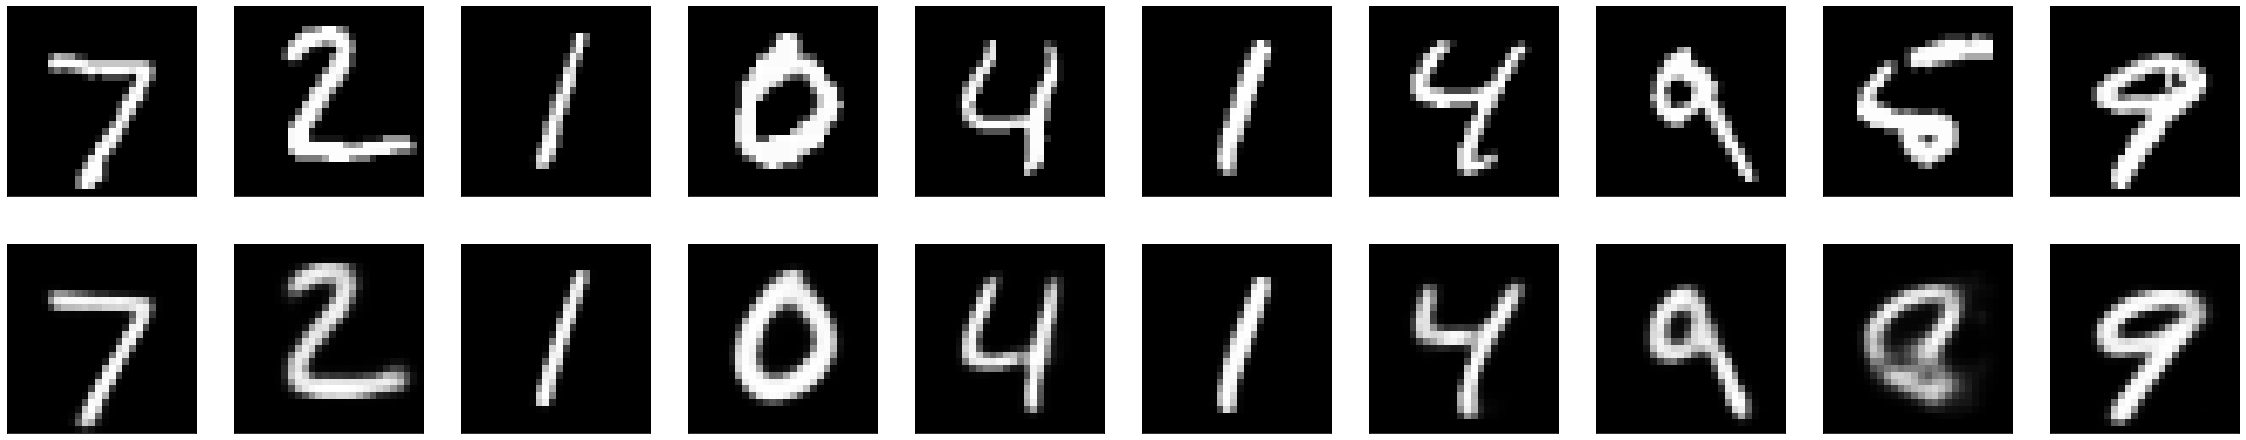

(10, 10)


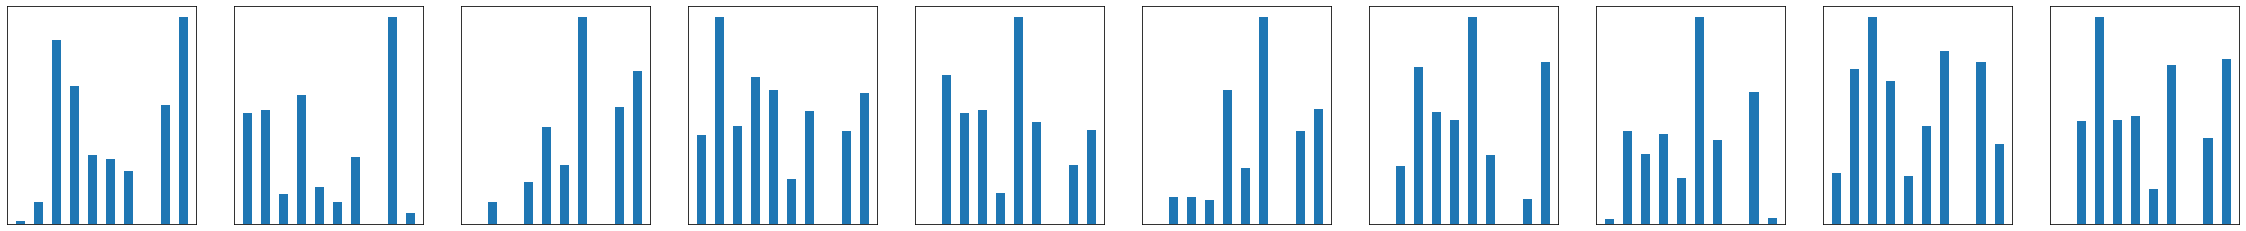

In [23]:
sparseconvmax_ae = SparseConvolutionMaxpoolAutoEncoder()

sparseconvmax_ae.train(30000,keep_prob=1)

code = sparseconvmax_ae.plot_test(10, draw_code=True)

### 畫出第一層filter

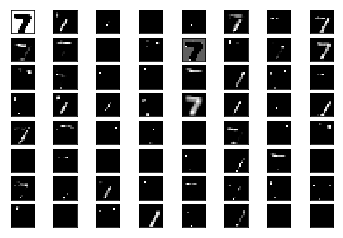

In [24]:
image1 = mnist.test.images[0]
sparseconvmax_ae.plot_conv_layer(sparseconvmax_ae.h_e[0], image1, 64)

### 畫出每個維度特徵圖

code shape: (10, 10)
layer shape: (?, 10)
image shape: (10, 28, 28, 1)


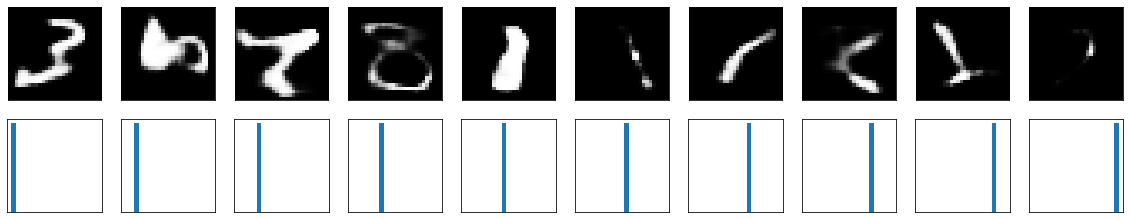

In [25]:
#temp = np.zeros(shape=(10,784))
code_test = np.zeros(shape=(10,10))

for i in range(len(code_test)):
    code_test[i,i] = 0.3
    
sparseconvmax_ae.plot_decode(code_test)

## Denoise Sparse Convolution AutoEncoder with max pooling

- [利用卷积自编码器对图片进行降噪 - 知乎](https://zhuanlan.zhihu.com/p/27902193)


- [numpy.random.randn — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randn.html)

In [26]:
class DenoiseSparseConvolutionMaxpoolAutoEncoder(SparseConvolutionMaxpoolAutoEncoder):
    def init_input_place(self):
        self.x_input = tf.placeholder(tf.float32, shape=[None, 784])
        self.x_input_reshape = tf.reshape(self.x_input, [-1, 28, 28, 1]) #28 X 28 X 1
        
        self.x_target = tf.placeholder(tf.float32, shape=[None, 784])
        self.x_target_reshape = tf.reshape(self.x_target, [-1, 28, 28, 1]) #28 X 28 X 1
        
        self.keep_prob = tf.placeholder(tf.float32)
        
    def add_noise(self, imgs):
        # 加入噪声
        noise_factor = 0.5
        #print(*imgs.shape)
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        #noisy_imgs = imgs 
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        return noisy_imgs
    
    def train_data_gen(self,n=60, keep_prob=1):
        batch = mnist.train.next_batch(n)[0]
        noise_batch = self.add_noise(batch)
        feed_dict = {self.x_input:noise_batch, self.x_target:batch, self.keep_prob:keep_prob}
        return noise_batch, feed_dict
    
    def test_data_gen(self,n=10,keep_prob=1):
        batch = mnist.test.images[0:n, :]
        noise_batch = self.add_noise(batch)
        feed_dict = {self.x_input:noise_batch, self.x_target:batch, self.keep_prob:keep_prob}
        return noise_batch, feed_dict
    

/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


max_pool_2x2
(?, 28, 28, 64)
(?, 14, 14, 64)
max_pool_2x2
(?, 14, 14, 64)
(?, 7, 7, 64)
max_pool_2x2
(?, 7, 7, 32)
(?, 4, 4, 32)
max_pool_2x2
(?, 4, 4, 32)
(?, 2, 2, 32)
max_pool_2x2
(?, 2, 2, 10)
(?, 1, 1, 10)
max_unpool_2x2
(?, 1, 1, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 2, 2, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 4, 4, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 7, 7, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 14, 14, 64)
(?, ?, ?, 64)
step 0, loss 0.702453
step 100, loss 0.285679
step 200, loss 0.263029
step 300, loss 0.243743
step 400, loss 0.244047
step 500, loss 0.227858
step 600, loss 0.217456
step 700, loss 0.228861
step 800, loss 0.229104
step 900, loss 0.222807
step 1000, loss 0.219497
step 1100, loss 0.212928
step 1200, loss 0.216889
step 1300, loss 0.211671
step 1400, loss 0.217852
step 2000, loss 0.20355
step 3000, loss 0.206589
step 4000, loss 0.197474
step 5000, loss 0.190936
step 6000, loss 0.184199
step 7000, loss 0.181268
step 8000, loss 0.195046
step 9000, loss 0.197997
step 10000

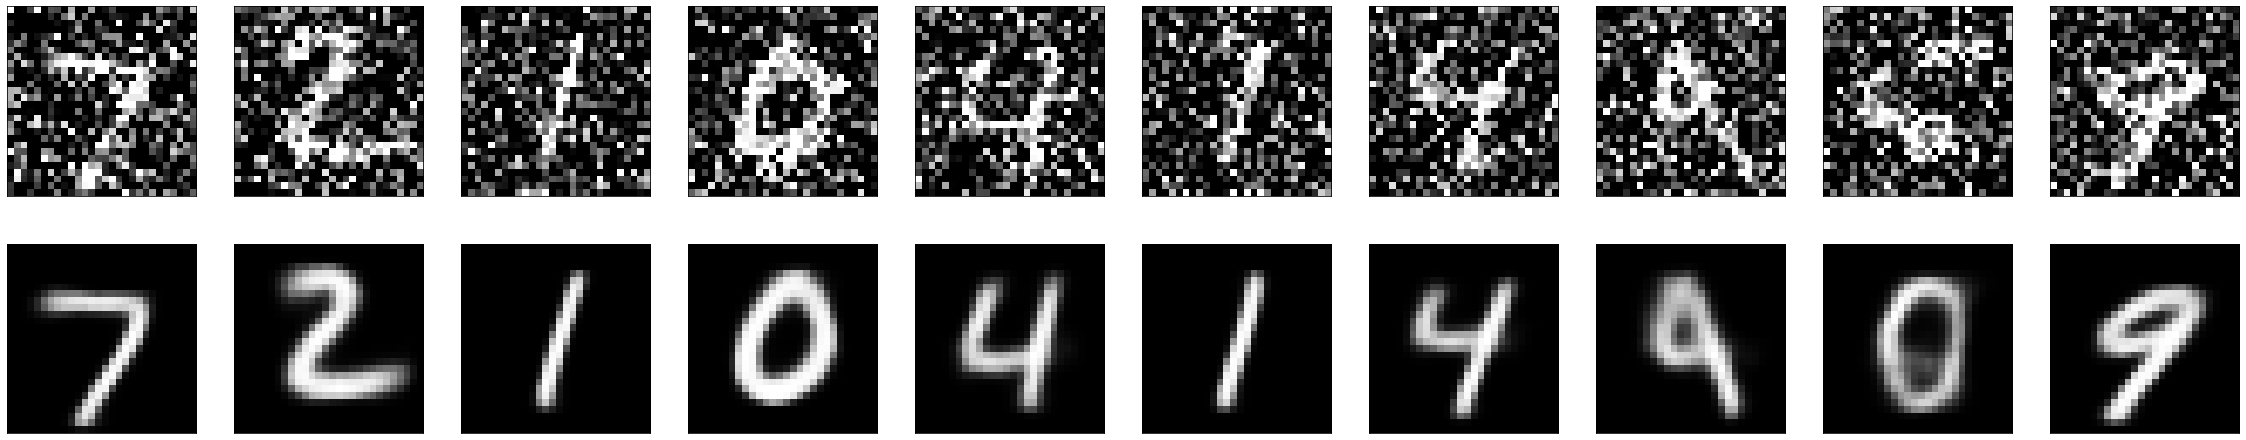

(10, 10)


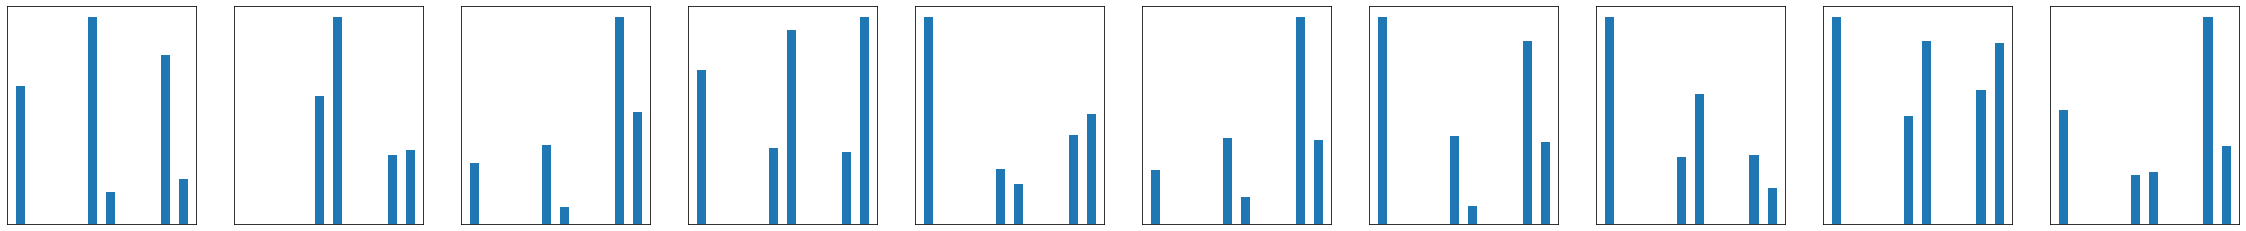

In [27]:
denoisesparseconvmax_ae = DenoiseSparseConvolutionMaxpoolAutoEncoder()

denoisesparseconvmax_ae.train(30000)

code = denoisesparseconvmax_ae.plot_test(10, draw_code=True)

code shape: (10, 10)
layer shape: (?, 10)
image shape: (10, 28, 28, 1)


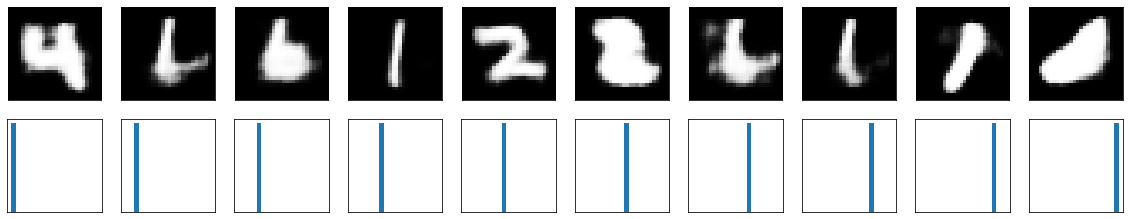

In [28]:
#temp = np.zeros(shape=(10,784))
code_test = np.zeros(shape=(10,10))

for i in range(len(code_test)):
    code_test[i,i] = 0.3
    
denoisesparseconvmax_ae.plot_decode(code_test)